In [1]:
import os
import itertools as it
from collections import Counter

import numpy as np
import pandas as pd

import statsmodels
from statsmodels.stats.multitest import multipletests
import statistics as stats
import scipy

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display_html 

import warnings
warnings.filterwarnings('ignore')

# change dir to project dir
if 'changed' not in globals():
    os.chdir('../../../')
    changed = 1
    
# output directory for simulations
mp_data_dir = 'results/motif_pairs/Motif_Pairs_100000_only_chr/'

## Load all the sample groups

In [2]:
# loading bplus samples; temporarily using old data
tmpl_fn = os.path.join(mp_data_dir, 'a_plus/', '{}/', 'P_values_agg.tsv')
complete_aplus_samples = os.listdir(os.path.join(mp_data_dir, 'a_plus/'))
complete_aplus_samples = [x for x in complete_aplus_samples if os.path.exists(tmpl_fn.format(x))]

# # loading bplus samples; temporarily using old data
# tmpl_fn = os.path.join(mp_data_dir, 'b_plus/', '{}/', 'P_values_agg.tsv')
# complete_bplus_samples = os.listdir(os.path.join(mp_data_dir, 'b_plus/'))
# complete_bplus_samples = [x for x in complete_bplus_samples if os.path.exists(tmpl_fn.format(x))]

# # loading ctcf samples; temporarily using old data
# tmpl_fn = os.path.join(mp_data_dir, 'ctcf_test/', '{}/', 'P_values_agg.tsv')
# samples_control = os.listdir(os.path.join(mp_data_dir, 'ctcf_test/'))
# samples_control = [x for x in samples_control if os.path.exists(tmpl_fn.format(x))]

## Summarize the Data

We start by finding the top motifs according to the FIMO data then use these to filter the motif pair simulation analysis. 

In [3]:
# Number of Top Motifs you want to see (Can be user specified)
top_motif_count = 50

# Loop through all samples of interest
sample_batch = 'a_plus'
fimo_dir = '/mnt/bioadhoc-temp/Groups/vd-ay/kfetter/hichip-db-loop-calling/biorep_merged/results/motif_analysis/meme/fimo/'

entries = []
for k, sample_name in enumerate(complete_aplus_samples[0:6]):

    # Load raw fimo + loop data
    sample_file_path = os.path.join(fimo_dir, sample_batch, sample_name, 'summarize_results/summary.txt')
    df = pd.read_csv(sample_file_path, sep='\t', header=0)

    # Filter motifs
    filter_df = df[(df['motif_ID_1'] != 'None' ) & (df['motif_ID_2'] != 'None')]
    filter_df = filter_df[(~filter_df['motif_name_1'].isna()) & (~filter_df['motif_name_2'].isna())].reset_index(drop=True)
    
    # Initialize the anchor slots data structure for entire set
    anchor_slots = {}
    anchor_ids = []

    # Count the number of loops and anchors
    for i, sr in filter_df.iterrows():

        # Create anchor ids
        anchor1_id = '{}-{}-{}'.format(sr['chr1'], sr['start1'], sr['end1'])
        anchor2_id = '{}-{}-{}'.format(sr['chr2'], sr['start2'], sr['end2'])

        if anchor1_id not in anchor_slots:
            motifs1 = list(sr.motif_name_1.split(','))
            anchor_slots[anchor1_id] = list(set(motifs1))
            anchor_ids.append(anchor1_id)

        if anchor2_id not in anchor_slots:
            motifs2 = list(sr.motif_name_2.split(','))
            anchor_slots[anchor2_id] = list(set(motifs2))
            anchor_ids.append(anchor2_id)

    total_loops = len(df)
    total_anchors = len(anchor_slots)

    # Count then number of anchors without motifs
    anchors_with_mps = [anchor for anchor, mp_list in anchor_slots.items() if mp_list[0] != 'None']
    total_anchors_with_mps = len(anchors_with_mps)

    # Count then number of anchors with motifs
    anchors_without_mps = [anchor for anchor, mp_list in anchor_slots.items() if mp_list[0] == 'None']
    total_anchors_without_mps = len(anchors_without_mps)

    # Count the number of unique motifs
    all_motifs = []
    for anchor, mp_list in anchor_slots.items():
        all_motifs.extend(mp_list)
    total_motif_events = len(all_motifs)
    total_motifs = len(set(all_motifs))

    ## Create list of anchor IDs ##
    filter_anchor_slots = {}
    filter_anchor_ids = []

    ## For dataset of analysis
    for i, sr in filter_df.iterrows():

        # Create anchor ids
        filter_anchor1_id = '{}-{}-{}'.format(sr['chr1'], sr['start1'], sr['end1'])
        filter_anchor2_id = '{}-{}-{}'.format(sr['chr2'], sr['start2'], sr['end2'])

        if filter_anchor1_id not in filter_anchor_slots:
            filter_motifs1 = list(sr.motif_name_1.split(','))
            filter_anchor_slots[filter_anchor1_id] = list(set(filter_motifs1))
            filter_anchor_ids.append(filter_anchor1_id)

        if filter_anchor2_id not in filter_anchor_slots:
            filter_motifs2 = list(sr.motif_name_2.split(','))
            filter_anchor_slots[filter_anchor2_id] = list(set(filter_motifs2))
            filter_anchor_ids.append(filter_anchor2_id)

    filter_total_loops = len(filter_df)
    filter_total_anchors = len(filter_anchor_slots)

    filter_anchors_with_mps = [anchor for anchor, mp_list in filter_anchor_slots.items() if mp_list[0] != 'None']
    filter_total_anchors_with_mps = len(filter_anchors_with_mps)

    filter_anchors_without_mps = [anchor for anchor, mp_list in filter_anchor_slots.items() if mp_list[0] == 'None']
    filter_total_anchors_without_mps = len(filter_anchors_without_mps)

    filter_all_motifs = []
    for anchor, mp_list in filter_anchor_slots.items():
        filter_all_motifs.extend(mp_list)
    filter_total_motif_events = len(filter_all_motifs)
    filter_total_motifs = len(set(filter_all_motifs))

    # Set up counter
    motif_pair_counter = Counter()

    # Loop through all entries in dataframe
    uniq_motif_pairs = []
    for num in range(len(filter_df)):

        # Get motifs 1
        motifs1 = list(filter_df.motif_name_1[num].split(','))

        # Get motifs 2
        motifs2 = list(filter_df.motif_name_2[num].split(','))

        # Get the cross product of all 
        combos = list(it.product(motifs1, motifs2))

        # Filter data to take into account (X,Y) vs (Y,X)
        combos = [(x[0], x[1]) if x[0] < x[1] else (x[1], x[0]) for x in combos]

        # Get chromsome attributes for Chromsome 1
        chr1_name = str(filter_df['chr1'][num])
        chr1_start = str(filter_df['start1'][num])
        chr1_end = str(filter_df['end1'][num])

        # Get chromosome attributes for Chromsome 2
        chr2_name = str(filter_df['chr2'][num])
        chr2_start = str(filter_df['start2'][num])
        chr2_end = str(filter_df['end2'][num])

        # Record them in counter
        for p in combos:
            motif_pair_counter[p] += 1
            uniq_motif_pairs.append(p)

    # Get unique list of motifs
    uniq_motif_pairs = list(set(uniq_motif_pairs))

    # Count number of raw motifs across anchors
    count_df = []
    for motif, value in Counter(filter_all_motifs).items():
        entry = {'Motif' : motif, 'Count': value, 'Percent': (value / len(filter_all_motifs)) * 100}
        count_df.append(entry)
    count_df = pd.DataFrame(count_df)

    # Get frequency of motifs
    top_freq_motifs = count_df.sort_values('Percent',ascending=False).head(top_motif_count)['Motif'].tolist()
    top_motifs_list = '|'.join(top_freq_motifs)

    ### Read in data of sample
    fn = os.path.join(mp_data_dir, sample_batch, sample_name, 'P_values_agg.tsv')
    mp_data = pd.read_table(fn)
    
    # Keep motif pairs where both motifs show up in top frequent motifs
    mp_data['Contain_1'] = mp_data['Motif1'].str.contains(top_motifs_list)
    mp_data['Contain_2'] = mp_data['Motif2'].str.contains(top_motifs_list)
    data_qvalues = mp_data[(mp_data['Contain_1'] == True) & (mp_data['Contain_2'] == True)]
    final_data_qvalues = data_qvalues.copy()

    # Run Q value correction
    final_data_qvalues['Q_value'] = list(multipletests(data_qvalues['P_value'], method='fdr_bh', is_sorted=False)[1])
    
    # Save P values less than or equal to 10%
    p_sig_values = final_data_qvalues[(final_data_qvalues['P_value'] <= 0.10)][['Motif1', 'Motif2', 'Obs_Count', 'Q_value']]

    # Show top 10 occuring motif pairs
    tmpdf = p_sig_values.sort_values(by=['Obs_Count'], ascending=False).head(10)

    # Save table temporary
    tmpdf_styler = tmpdf.style.set_table_attributes("""style='display:inline'" "index_names=False""").set_caption(sample_name).hide(axis='index')
    entry = {'df' + str(k): [tmpdf, tmpdf_styler._repr_html_()]}

    # Append to list of tables
    entries.append(entry)

### Example code below to show 6 tables

In [4]:
### Input number of tables you want to display
for i in range(0, 6):
    if i == 0:
        all_tables = entries[i]['df' + str(i)][1]
    else:
        all_tables = all_tables + entries[i]['df' + str(i)][1]
display_html(all_tables, raw=True)

Motif1,Motif2,Obs_Count,Q_value
ZNF460,ZNF460,3227,0.000000
ZNF135,ZNF460,3100,0.000000
KLF5,ZNF460,2898,0.297663
KLF4,ZNF460,2700,0.333724
ZNF320,ZNF460,2345,0.442139
CTCF,ZNF460,2331,0.333724
KLF5,PATZ1,2093,0.214727
KLF5,PRDM9,1859,0.392085
MAZ,PRDM9,1848,0.285878
KLF15,KLF5,1785,0.074027


### Generate QQ Plots for a Few Samples

In [5]:
def calculate_qqplot_df(pvals_df):
    """
    Function to calculate qqplot data from pvals.
    """ 
    
    # Transform P-values via log 10
    pvalues = list(pvals_df['P_value'])
    log10_pvalues = list(-np.log10(pvals_df['P_value']))
    
    # Q value correction graph
    rejected, qvalues, _, _ = multipletests(pvals_df['P_value'], method='fdr_bh')
    log10_qvalues = -np.log10(qvalues)

    # Create uniform theory distribution    
    unif_graph = np.random.uniform(0, 1, len(pvals_df))
    log_unif = list(-np.log10(unif_graph))

    # Create random values for theory distribution
    norm_graph = np.random.normal(0, 1, len(pvals_df))

    # Create random values for theory distribution
    exp_graph = np.random.exponential(1, len(pvals_df))
    log_exp = list(-np.log10(exp_graph))

    # Sort all the distributions
    log10_pvalues.sort()
    log10_qvalues.sort()
    pvalues.sort()
    qvalues.sort()
    norm_graph.sort()
    unif_graph.sort()
    exp_graph.sort()
    log_unif.sort()
    log_exp.sort()
    
    # Make a dataframe of the different values
    data_graph_qq = pd.DataFrame({'log10_pvalue': log10_pvalues, 'log10_qvalues': log10_qvalues,
                                    'log_unif': log_unif, 'log_exp': log_exp, 'Q-value': qvalues,
                                    'P-value': pvalues, 'norm': norm_graph, 'unif': unif_graph, 'exp': exp_graph})
    
    return(data_graph_qq)    

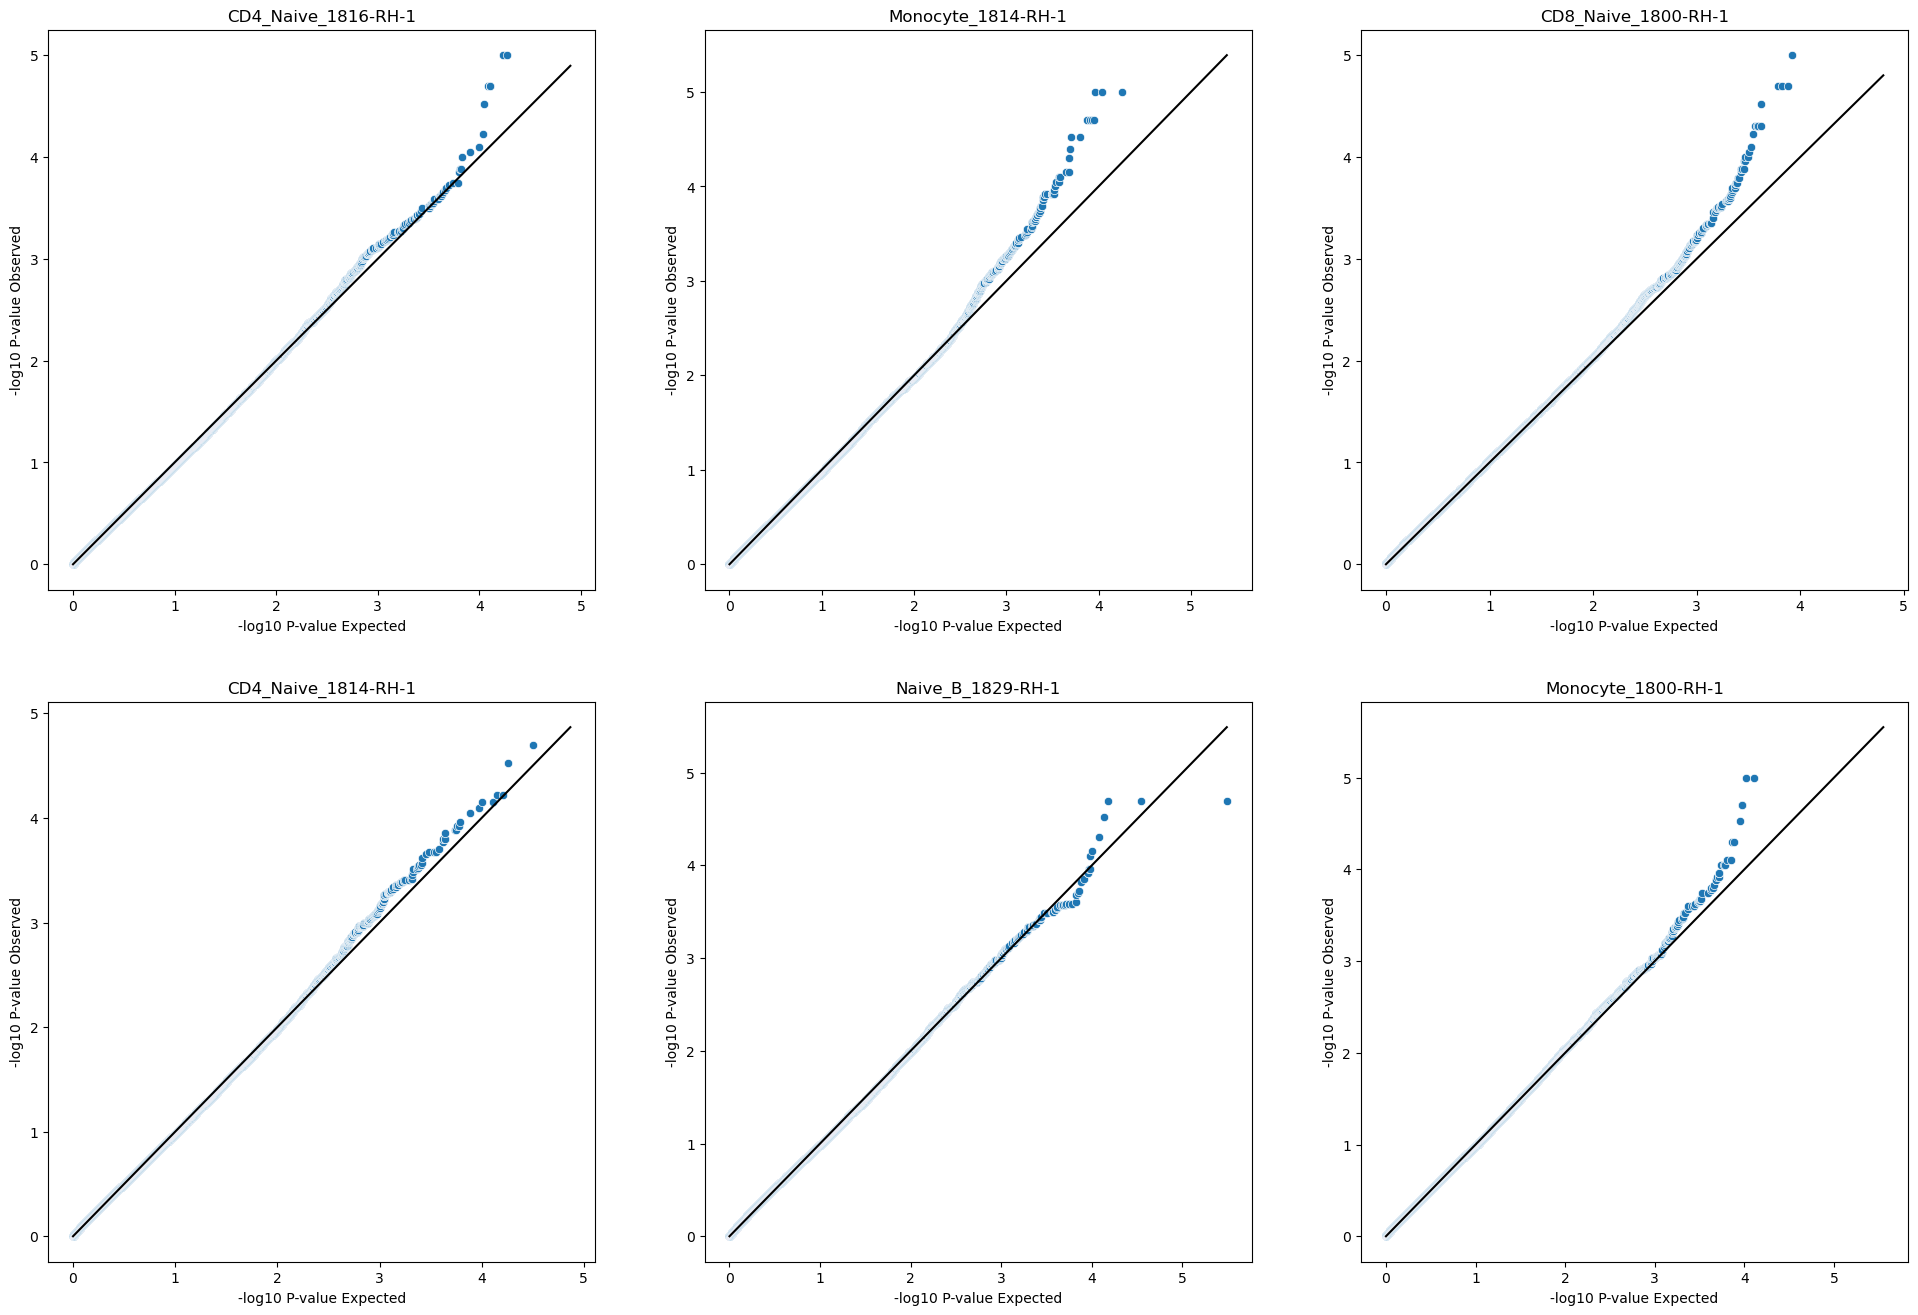

In [6]:
fig, axes  = plt.subplots(2, 3, figsize=(24, 16))
axes = axes.flatten()

for k, sample in enumerate(complete_aplus_samples[0:6]):

    # Load the data and generate qqplot data
    fn = os.path.join(mp_data_dir, 'a_plus/', sample, 'P_values_agg.tsv')
    pvals_df = pd.read_table(fn)
    qqplot_df = calculate_qqplot_df(pvals_df)
    
    # # calculate chi-squared scores 
    # chisqvalues = []
    # for pvalue in qqplot_df['P-value']:
    #     chisqvalues.append(scipy.stats.chi2.ppf(1 - pvalue, 1))
    # median_chi = scipy.stats.chi2.ppf(0.5, 1)
    # median_obs = stats.median(chisqvalues)
    # print('GIF ' + sample + ' ' + str(median_obs / median_chi))
    
    # Generate the qqplots
    ax = axes[k]
    period_num = sample.find('.', 2)
    graph_title = sample[:period_num]
    
    p1 = sns.scatterplot(data=qqplot_df, x='log_unif', y='log10_pvalue', ax=ax)
    p1.set(title=graph_title, xlabel='-log10 P-value Expected', ylabel='-log10 P-value Observed')
    p2 = sns.lineplot(data=qqplot_df, x='log_unif', y='log_unif', color='black', ax=ax)

### QQ Plots Graph for All samples and Inflation Factors per Sample

#### A+ Samples

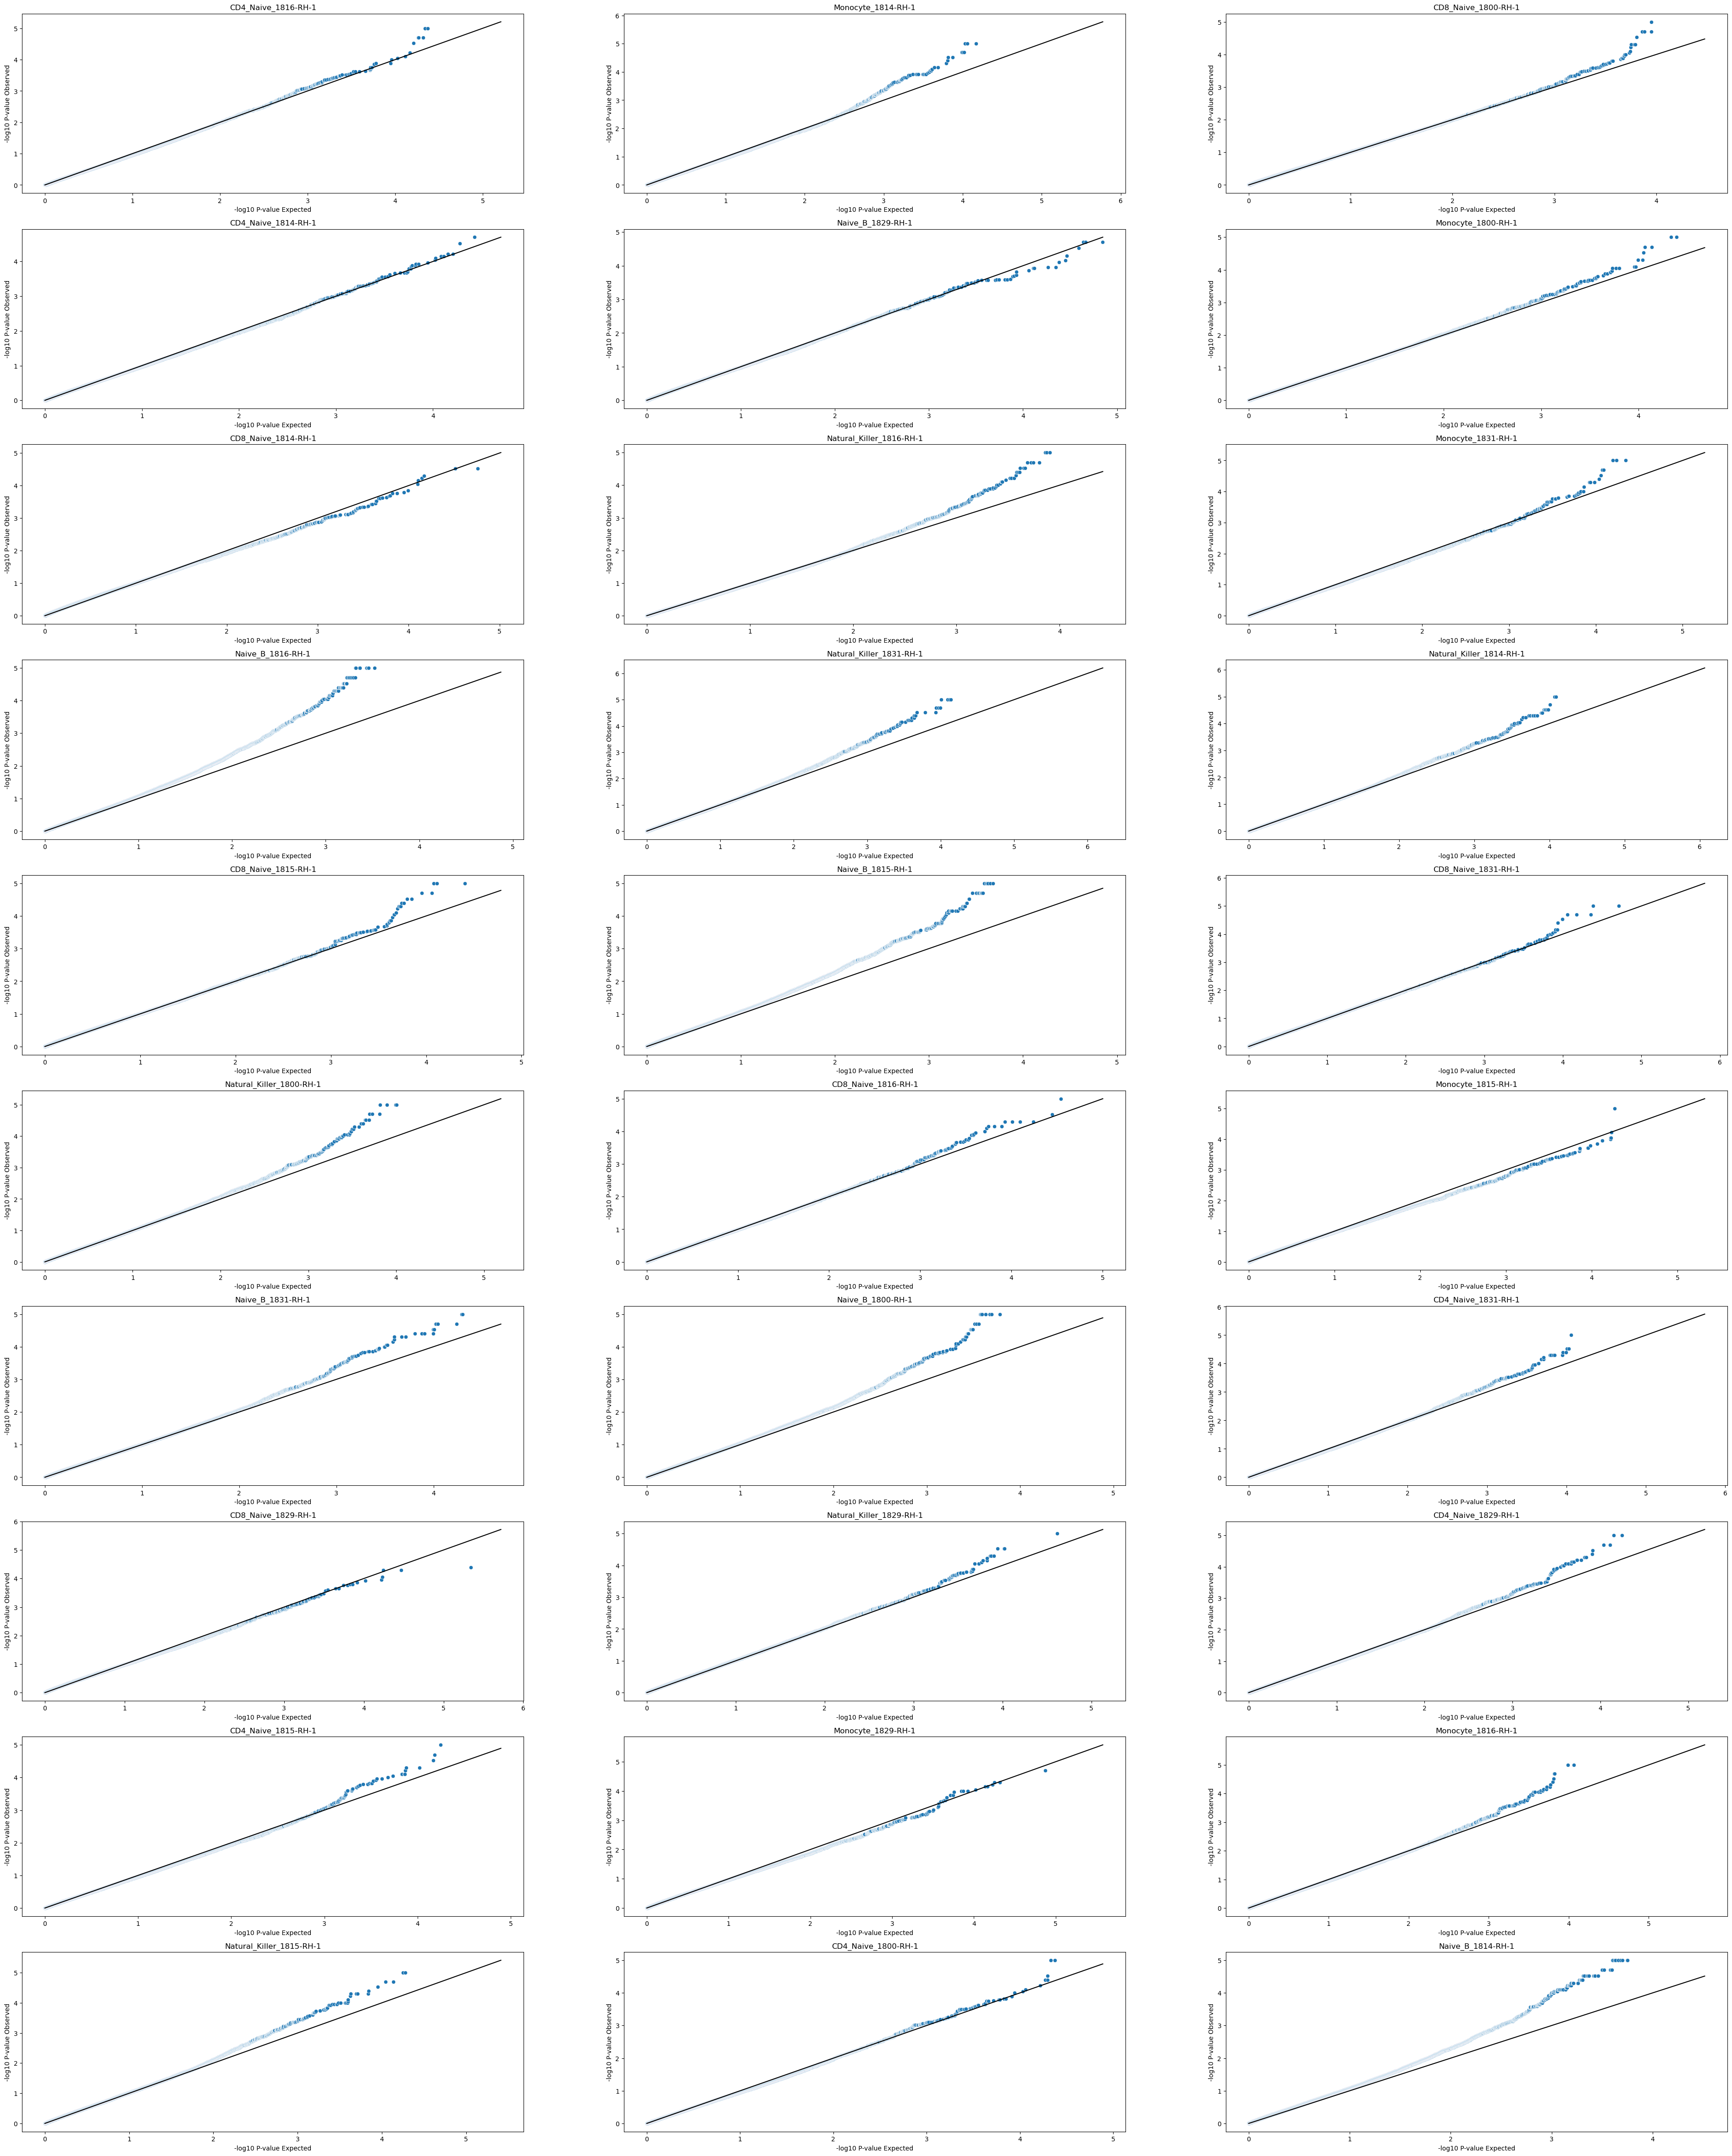

In [7]:
fig, axes  = plt.subplots(10, 3, figsize=(48, 60))
axes = axes.flatten()

for k, sample in enumerate(complete_aplus_samples):
    
    # Load the data and generate qqplot data
    fn = os.path.join(mp_data_dir, 'a_plus/', sample, 'P_values_agg.tsv')
    if not os.path.exists(fn):
        continue
    
    pvals_df = pd.read_table(fn)
    qqplot_df = calculate_qqplot_df(pvals_df)
    
    # calculate chi-squared scores, takes some time
    # chisqvalues = []
    # for pvalue in qqplot_df['P-value']:
    #     chisqvalues.append(scipy.stats.chi2.ppf(1 - pvalue, 1))
    # median_chi = scipy.stats.chi2.ppf(0.5, 1)
    # median_obs = stats.median(chisqvalues)
    # print('GIF ' + sample + ' ' + str(median_obs / median_chi))
    
    # Generate the qqplots
    ax = axes[k]
    period_num = sample.find('.', 2)
    graph_title = sample[:period_num]
    
    p1 = sns.scatterplot(data=qqplot_df, x='log_unif', y='log10_pvalue', ax=ax)
    p1.set(title=graph_title, xlabel='-log10 P-value Expected', ylabel='-log10 P-value Observed')
    p2 = sns.lineplot(data=qqplot_df, x='log_unif', y='log_unif', color='black', ax=ax)

#### B+ Samples

In [8]:
# fig, axes  = plt.subplots(10, 3, figsize=(48, 60))
# axes = axes.flatten()

# for k, sample in enumerate(complete_bplus_samples):
    
#     # Load the data and generate qqplot data
#     fn = os.path.join(mp_data_dir, 'b_plus/', sample, 'P_values_agg.tsv')
#     if not os.path.exists(fn):
#         continue
    
#     pvals_df = pd.read_csv(fn)
#     qqplot_df = calculate_qqplot_df(pvals_df)
    
#     # calculate chi-squared scores, takes some time
#     # chisqvalues = []
#     # for pvalue in qqplot_df['P-value']:
#     #     chisqvalues.append(scipy.stats.chi2.ppf(1 - pvalue, 1))
#     # median_chi = scipy.stats.chi2.ppf(0.5, 1)
#     # median_obs = stats.median(chisqvalues)
#     # print("GIF "+ sample + " " + str(median_obs / median_chi))
    
#     # Generate the qqplots
#     ax = axes[k]
#     period_num = sample.find('.', 2)
#     graph_title = sample[:period_num]
    
#     p1 = sns.scatterplot(data=qqplot_df, x="log_unif", y="log10_pvalue", ax=ax)
#     p1.set(title=graph_title, xlabel="-log10 P-value Expected", ylabel="-log10 P-value Observed")
#     p2 = sns.lineplot(data=qqplot_df, x="log_unif", y="log_unif", color="black", ax=ax)